# Introduction

   **Chennai** also known as **Madras** is the capital of the **Indian state of Tamil Nadu**. Chennai is among the **most-visited Indian cities by foreign tourists**. Tourism-guide publisher **Lonely Planet** named Chennai as **one of the top ten cities in the world to visit in 2015**. Chennai was ranked the **43rd-most visited city in the world** for the year 2015. The **Quality of Living Survey** rated Chennai as the **safest city in India**. Chennai attracts 45 percent of health tourists visiting India, and 30 to 40 percent of domestic health tourists. **National Geographic** mentioned Chennai as the **only South Asian city** to feature in its 2015 **"Top 10 food cities"** list. Chennai was also named the **ninth-best cosmopolitan city in the world** by Lonely Planet. In October 2017, Chennai was added to the **UNESCO Creative Cities Network (UCCN) list for its rich musical tradition**.

### Business Problem

In recent days, the **tourism of this beautiful city has decreased**. Tourism not only adds to the country's economy but is a core part of income. How do we increase tourism and bring back the popularity of the city? In-order to achieve this, we need the **tourists to have a good experience and moreover a personalized one**. We can achieve this with the help of data science.

### Target Audience

With all this tourist attraction taken into account, a system that can find a place suitable for the tourist to vist during their stay will be helpful. Our goal is to **identify places based on their rating & pricing** and make it visible to the tourists in-order for them **to choose a place to visit based on their budget and based on the venue's rating**.
   
   We will be clustering the places to visit based on the data we recieve from the **Foursquare API** & **Zomato API**.

# Data

Our objective is to search within a **5km radius of Chennai** located at the **Latitude : 13.0827° N** & **Longitude : 80.2707° E**. Using the FoursquareAPI & ZomatoAPI the data mentioned below is retrieved. Based on the Venue Name, Latitude & Longitude obtained from the FoursquareAPI we request for data from the ZomatoAPI. We have collected a total of **120 Venues within a 5km radius** of the geographical co-ordinates of Chennai. Since we are using two datasets each from different API, there maybe some noise. In-order to clean this data, we are eliminating venues with latitude & longitude values more than 0.0004. On cleaning this data we are left with **75venues** to obtain a working model.

The following data has been collected from the **FoursquareAPI** :
* Venue Name
* Category
* Latitude
* Longitude

The following data has been collected from the **ZomatoAPI** :
* Average Price for Two People
* Price Range
* Rating
* Address

### Importing Basic Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize
import requests
import folium

First we have to locate Chennai on the map, we are doing this by **providing the Latitude & Longitude co-ordinates for Chennai**.

In [2]:
chennai_latitude = 13.0827
chennai_longitude = 80.2707
print('The Geo Co-ordinates of Chennai, India are \nLatitude : {}\nLongitude : {}'.format(chennai_latitude,chennai_longitude))

The Geo Co-ordinates of Chennai, India are 
Latitude : 13.0827
Longitude : 80.2707


Now we can pinpoint the location of chennai onto the map using the latitude & longitude co-ordinates with the help of the **folium library.**

In [3]:
chennai = folium.Map(location = [chennai_latitude,chennai_longitude], zoom_start = 15)
folium.Marker([chennai_latitude,chennai_longitude]).add_to(chennai)
chennai

In-order to access the FoursquareAPI, we need to specify the developer's **Client ID, Client Secret & API Version.**

In [4]:
client_id = 'SPJ5ZZH2JCBKLK3Y5HF51JBNPK5GGGPI2J43MDND3Z3MFD2L'
client_secret = 'Y1J35FIYYFC1LUW3ATM0TVBTB1E3TVY4ALG2F2FZXSXYNCFB'
version = '20180605'

Now we define a function called **get_category_type to retrieve categories of each venue**.

In [5]:
def get_category_type(row):
    categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now with the help of a while loop, we will be requesting data from the FoursquareAPI. We must **specify the Client ID, Client Secret, API Version, Chennai-Latitude, Chennai-Longitude, Search Radius (5km) & the limit**.

In [6]:
fs_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])
radius = 5000 
limit = 100
offset = 0
total_venues = 0
while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(client_id, 
                                                                        client_secret, 
                                                                        version, 
                                                                        chennai_latitude, 
                                                                        chennai_longitude, 
                                                                        radius,
                                                                        limit,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]
    
    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)
    
    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    fs_venues = pd.concat([fs_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

fs_venues = fs_venues.reset_index(drop = True)
print("Total Number of Venues Retrieved : {}".format(total_venues))

Total Number of Venues Retrieved : 120


Now with the **venues retrieved and the data for each venue stored in the dataframe fs_venues**, we can now visualize the locations of each venue on the map with the help of the folium library.

In [30]:
fs_chennai_map = folium.Map(location = [chennai_latitude, chennai_longitude], zoom_start = 13)
for name, lat, lng in zip(fs_venues['name'], fs_venues['lat'], fs_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = 'blue',
        fill_opacity = 0.5,
        parse_html = False).add_to(fs_chennai_map)  
fs_chennai_map

Now in-order to get data about the **rating & pricing of each venue we have to use the ZomatoAPI**. We **must specify our unique user-key**. With the help of a for loop **we send a request to the ZomatoAPI with the details of latitude, longitude, ... for each venue & retrieve the rating, pricing, address, ... for the respective venue** from the ZomatoAPI. The venues are stored in a new dataframe **z_venues.**

In [8]:
headers = {'user-key': 'f7cd1d6c3bc13dc7e6a88c6ad92d7f49'}
venues_information = []

for index, row in fs_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
z_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

Now with the **venues retrieved and the data for each venue stored in the dataframe z_venues**, we can now visualize the locations of each venue on the map with the help of the folium library.

In [29]:
z_chennai_map = folium.Map(location = [chennai_latitude, chennai_longitude], zoom_start = 13)
for name, lat, lng in zip(z_venues['venue'], z_venues['latitude'], z_venues['longitude']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'orange',
        fill = True,
        fill_color = 'orange',
        fill_opacity = 0.5,
        parse_html = False).add_to(z_chennai_map)  
z_chennai_map

With the help of a lambda function we are **rounding the latitude & longitude values to 4  decimal digits** for both the ZomatoAPI data & the FoursquareAPI data.

In [9]:
fs_venues['lat'] = fs_venues['lat'].apply(lambda lat: round(float(lat), 4))
fs_venues['lng'] = fs_venues['lng'].apply(lambda lng: round(float(lng), 4))
z_venues['latitude'] = z_venues['latitude'].apply(lambda lat: round(float(lat), 4))
z_venues['longitude'] = z_venues['longitude'].apply(lambda lng: round(float(lng), 4))

Since we are using **2 dataframes -> fs_venues & z_venues**, there some **unwanted repeated data with slight deviations** in location. Therefor to remove this error we are **removing venues with a latitude & longitude difference greater than 0.0004.**

In [10]:
combine = pd.concat([fs_venues, z_venues], axis = 1)
combine['latitude_difference'] = combine['latitude'] - combine['lat']
combine['longitude_difference'] = combine['longitude'] - combine['lng']
filtered_venues = combine[(abs(combine['latitude_difference']) <= 0.0004) & (abs(combine['longitude_difference']) <= 0.0004)].reset_index(drop = True)
filtered_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,latitude_difference,longitude_difference
0,National Durbar Hotel,Indian Restaurant,13.0813,80.2706,Hotel Greens Gate,13.0812,80.2703,450.0,1.0,0,"12 & 13, V V Koil Street, Opposite Rippon Buil...",-0.0001,-0.0003
1,Bombay Lassi,Dessert Shop,13.0660,80.2712,Bombay Lassi,13.0659,80.2712,100.0,1.0,4.8,"8, Bahar Agan Street, Anna Salai, Ellis Road, ...",-0.0001,0.0000
2,Shree Mithai,Indian Restaurant,13.0721,80.2479,Shree Mithai,13.0722,80.2479,300.0,1.0,4.5,"18, Dr TV Road, Chetpet, Chennai",0.0001,0.0000
3,Nicky's Cafe & Fine Pastries,Café,13.0639,80.2598,Nicky's Cafe & Fine Pastries,13.0636,80.2597,750.0,2.0,4.2,"Fagun Mansion, 74, Ethiraj Salai, Egmore, Chennai",-0.0003,-0.0001
4,Kakada Ramprasad,Indian Restaurant,13.0904,80.2791,Kakada Ramprasad,13.0903,80.2791,450.0,1.0,4.4,"348/343, Ground Floor, Mint Street, Sowcarpet,...",-0.0001,0.0000
5,Fruit Shop On Greams Road,Juice Bar,13.0604,80.2544,The Cake World,13.0603,80.2545,500.0,2.0,3.1,"11/2, Greams Road, Near Police Station, Thousa...",-0.0001,0.0001
6,Express Avenue,Shopping Mall,13.0587,80.2642,House of Candy,13.0587,80.2643,200.0,1.0,0,"Express Avenue Mall, 2, Ground Floor, Hamleys ...",0.0000,0.0001
7,Sathyam Cinemas,Movie Theater,13.0555,80.2580,Blur Cafe,13.0554,80.2579,850.0,2.0,4.0,"8, 5th Floor, Sathyam Cinemas Complex, Thiruvi...",-0.0001,-0.0001
8,The Marina,Seafood Restaurant,13.0673,80.2521,The Marina,13.0672,80.2523,1600.0,3.0,4.5,"39, College Road, Nungambakkam, Chennai",-0.0001,0.0002
9,Hotel Welcome,Hotel,13.0857,80.2546,Welcome Hotel,13.0856,80.2545,250.0,1.0,4.5,"112/241, Purasawalkam High Road, Purasavakkam,...",-0.0001,-0.0001


Since we have a dataframe result with repeated columns after combining of both the dataframes, we must remove the repeated ones.

In [11]:
filtered_venues = filtered_venues.drop(columns = ['name', 'lat', 'lng', 'latitude_difference', 'longitude_difference'])

**Removing** the venues which have **0 rating (They are unrated)**.

In [12]:
filtered_venues = filtered_venues[filtered_venues['rating'] != 0.0]
print("Total venues available: {}".format(filtered_venues.shape[0]))
filtered_venues.head()

Total venues available: 75


,categories,venue,latitude,longitude,price_for_two,price_range,rating,address
1,Dessert Shop,Bombay Lassi,13.0659,80.2712,100.0,1.0,4.8,"8, Bahar Agan Street, Anna Salai, Ellis Road, ..."
2,Indian Restaurant,Shree Mithai,13.0722,80.2479,300.0,1.0,4.5,"18, Dr TV Road, Chetpet, Chennai"
3,Café,Nicky's Cafe & Fine Pastries,13.0636,80.2597,750.0,2.0,4.2,"Fagun Mansion, 74, Ethiraj Salai, Egmore, Chennai"
4,Indian Restaurant,Kakada Ramprasad,13.0903,80.2791,450.0,1.0,4.4,"348/343, Ground Floor, Mint Street, Sowcarpet,..."
5,Juice Bar,The Cake World,13.0603,80.2545,500.0,2.0,3.1,"11/2, Greams Road, Near Police Station, Thousa..."


**Renaming columns**, so the data can be understood easily.

In [13]:
data = filtered_venues.rename(columns = {'categories':'Category','venue':'Venue Name','latitude':'Latitude','longitude':'Longitude','price_for_two':'Price','price_range':'Price Range','rating':'Rating','address':'Venue Address'})
data

,Category,Venue Name,Latitude,Longitude,Price,Price Range,Rating,Venue Address
1,Dessert Shop,Bombay Lassi,13.0659,80.2712,100.0,1.0,4.8,"8, Bahar Agan Street, Anna Salai, Ellis Road, ..."
2,Indian Restaurant,Shree Mithai,13.0722,80.2479,300.0,1.0,4.5,"18, Dr TV Road, Chetpet, Chennai"
3,Café,Nicky's Cafe & Fine Pastries,13.0636,80.2597,750.0,2.0,4.2,"Fagun Mansion, 74, Ethiraj Salai, Egmore, Chennai"
4,Indian Restaurant,Kakada Ramprasad,13.0903,80.2791,450.0,1.0,4.4,"348/343, Ground Floor, Mint Street, Sowcarpet,..."
5,Juice Bar,The Cake World,13.0603,80.2545,500.0,2.0,3.1,"11/2, Greams Road, Near Police Station, Thousa..."
7,Movie Theater,Blur Cafe,13.0554,80.2579,850.0,2.0,4.0,"8, 5th Floor, Sathyam Cinemas Complex, Thiruvi..."
8,Seafood Restaurant,The Marina,13.0672,80.2523,1600.0,3.0,4.5,"39, College Road, Nungambakkam, Chennai"
9,Hotel,Welcome Hotel,13.0856,80.2545,250.0,1.0,4.5,"112/241, Purasawalkam High Road, Purasavakkam,..."
10,Indian Restaurant,Mathura Restaurant,13.0666,80.2690,500.0,2.0,4.0,"826, 2nd Floor, Tarapore Towers, Anna Salai, T..."
11,Kebab Restaurant,Kabab Corner,13.0600,80.2541,450.0,1.0,4.5,"12/1, Opposite Royal Enfield Showroom, Egmore,..."


Visualizing the cleaned data on a map with the help of the folium library.

In [14]:
filtered_chennai_map = folium.Map(location = [chennai_latitude, chennai_longitude], zoom_start = 13)
for name, lat, lng in zip(data['Venue Name'], data['Latitude'],data['Longitude']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'black',
        fill = True,
        fill_color = 'grey',
        fill_opacity = 0.7,
        parse_html = False).add_to(filtered_chennai_map)  
filtered_chennai_map

This **concludes the data gathering & data cleaning phase**. We have combined the data we acquired from both the dataframes -> ZomatoAPI & FoursquareAPI. We removed the data which had slight differences in latitude & longitude. We removed venues which had 0 rating (unrated). The obtained dataframe **"data"** is visualized in the above map.

# Methodology

In this project, we are focusing on **venues tourists can visit during their stay in Chennai**. We will be directing our efforts to **analyze venues with similar ratings & pricing**. We are limiting our analysis to a **5Km range** around Chennai.

In first step we have collected the required **data: location, rating & pricing of every venue within 5km of Chennai**. We have cleaned the data by **removing repeated locations & unrated venues**.

Second step in our analysis will be calculation and exploration of '**Rating & Pricing**' of each venue. With the help of **bar plots** we will be visualizing **the Number of venue categories & Number of ratings within 5Km of Chennai**. We will also visualize the **venue count vs. pricing** with the help of a **scatter plot**.

In third and final step we will focus on **identifying groups with the help of clustering (K-Means Clustering)**. We will be finding the **ideal K value with the help of elbow method**. The clusters will then be created and will describe **a group of venues with similar ratings & price ranges**. This will **help the tourist to identify where he or she would want to visit according to the venue's rating & the tourist's budget**.

# Analysis

Lets perform some basic exploratory data analysis & try to acquire some additional information about the venues. First lets **visualize the number of venue categories within the 5km radius of Chennai**.

<BarContainer object of 35 artists>

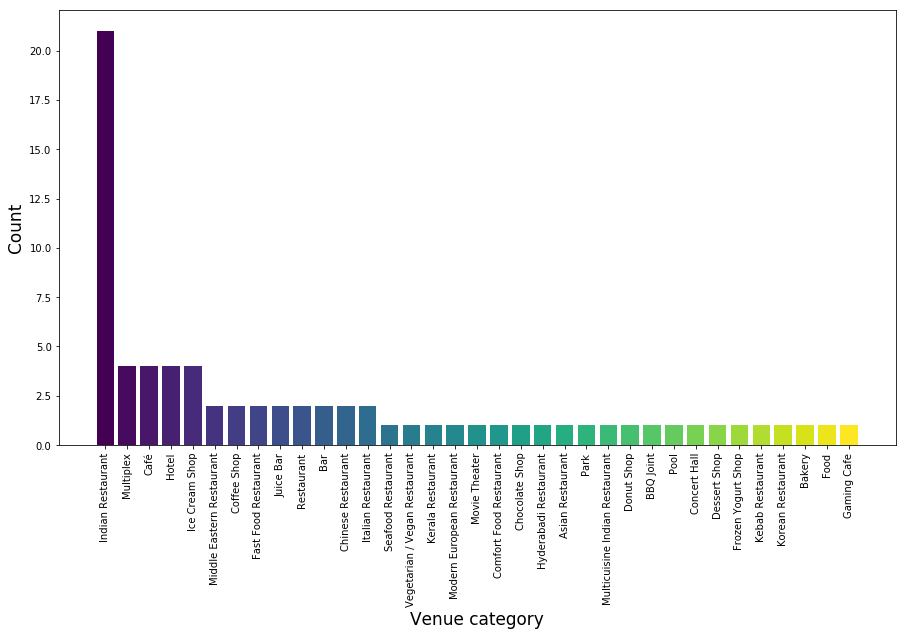

In [15]:
venue_graph = data['Category'].value_counts()
colors = cm.viridis(np.linspace(0, 1, len(venue_graph.index)))
plt.figure(figsize = (15, 8))
plt.xticks(rotation = 90)
plt.xlabel('Venue category', fontsize = 17)
plt.ylabel('Count', fontsize = 17)
plt.bar(venue_graph.index, venue_graph.values, color = colors)

From the above bar plot, it is obvious that there are a **lot of Indian Restaurants within the 5Km radius**. This is **good for tourists who want to try the local cuisine & experience the culture of Chennai**.

Now lets **visualize the number of counts for each rating**, where  **0 is the least & 5 is the highest rating**.

Text(0, 0.5, 'Count')

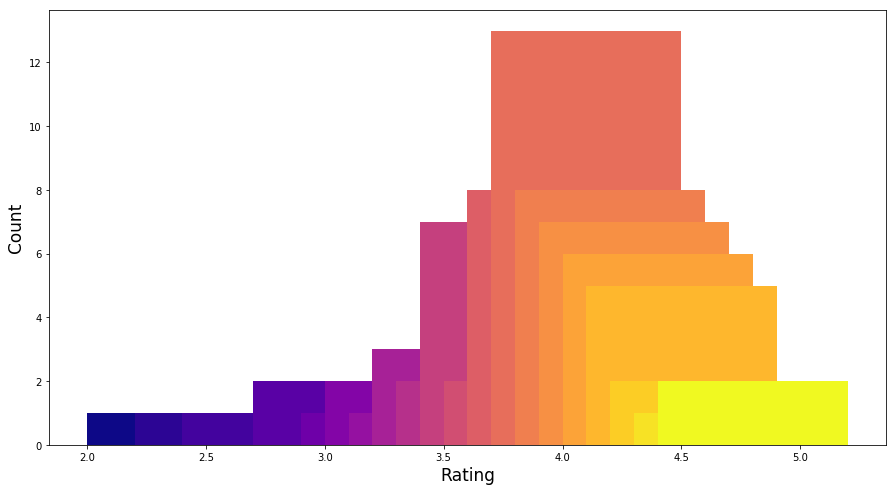

In [16]:
data['Rating'] = data['Rating'].astype(float)
rating = data['Rating'].value_counts().sort_index()
plt.figure(figsize = (15,8))
plt.bar(rating.index, rating.values, color = cm.plasma(np.linspace(0, 1, len(rating.index))))
plt.xlabel('Rating', fontsize = 17)
plt.ylabel('Count', fontsize = 17)

From the above bar plot, we can conclude that there are a **lot of venues with an average rating of 3.5-4.5**. This is **good for tourism, the rating indicates the customer/visitor satisfaction of the venue**.

In-order **to visualize the rating on the map, let us group the Rating into bins** where :
* 0-2.5    is **Bad**
* 2.5-3.2   is **Average**
* 3.2-4.2 is **Good**
* 4.2-5.0 is **Excellent**

In [17]:
bins = [0, 2.5, 3.2, 4.2, 5.0]
labels = ['Bad', 'Average', 'Good', 'Excellent']
data['Review'] = pd.cut(data['Rating'].astype(float), bins = bins, labels = labels, include_lowest = True)
data

,Category,Venue Name,Latitude,Longitude,Price,Price Range,Rating,Venue Address,Review
1,Dessert Shop,Bombay Lassi,13.0659,80.2712,100.0,1.0,4.8,"8, Bahar Agan Street, Anna Salai, Ellis Road, ...",Excellent
2,Indian Restaurant,Shree Mithai,13.0722,80.2479,300.0,1.0,4.5,"18, Dr TV Road, Chetpet, Chennai",Excellent
3,Café,Nicky's Cafe & Fine Pastries,13.0636,80.2597,750.0,2.0,4.2,"Fagun Mansion, 74, Ethiraj Salai, Egmore, Chennai",Good
4,Indian Restaurant,Kakada Ramprasad,13.0903,80.2791,450.0,1.0,4.4,"348/343, Ground Floor, Mint Street, Sowcarpet,...",Excellent
5,Juice Bar,The Cake World,13.0603,80.2545,500.0,2.0,3.1,"11/2, Greams Road, Near Police Station, Thousa...",Average
7,Movie Theater,Blur Cafe,13.0554,80.2579,850.0,2.0,4.0,"8, 5th Floor, Sathyam Cinemas Complex, Thiruvi...",Good
8,Seafood Restaurant,The Marina,13.0672,80.2523,1600.0,3.0,4.5,"39, College Road, Nungambakkam, Chennai",Excellent
9,Hotel,Welcome Hotel,13.0856,80.2545,250.0,1.0,4.5,"112/241, Purasawalkam High Road, Purasavakkam,...",Excellent
10,Indian Restaurant,Mathura Restaurant,13.0666,80.2690,500.0,2.0,4.0,"826, 2nd Floor, Tarapore Towers, Anna Salai, T...",Good
11,Kebab Restaurant,Kabab Corner,13.0600,80.2541,450.0,1.0,4.5,"12/1, Opposite Royal Enfield Showroom, Egmore,...",Excellent


Now we assign colors according to their rating bins. The corresponding colors are :
* 0-2.5     (Bad) is **red**
* 2.5-3.2   (Average) is **green**
* 3.2-4.2 (Good) is **lightblue**
* 4.2-5.0 (Excellent) is **darkblue**

We assign the colors to the marker and plot the markers on the map with the help of the folium library.

In [18]:
color_map = {'Bad': 'red', 'Average': 'green', 'Good': 'lightblue', 'Excellent': 'darkblue '}

chennai_map_review = folium.Map(location = [chennai_latitude,chennai_longitude], zoom_start = 13)

for name, address, latitude, longitude, rating in zip(data['Venue Name'], 
                                                          data['Venue Address'], 
                                                          data['Latitude'], 
                                                          data['Longitude'], 
                                                          data['Review']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating]),
        popup = label).add_to(chennai_map_review)  
chennai_map_review

Now lets **visualize the venue count against price for two** with the help of a **scatter plot**.

Text(0, 0.5, 'Venue Count')

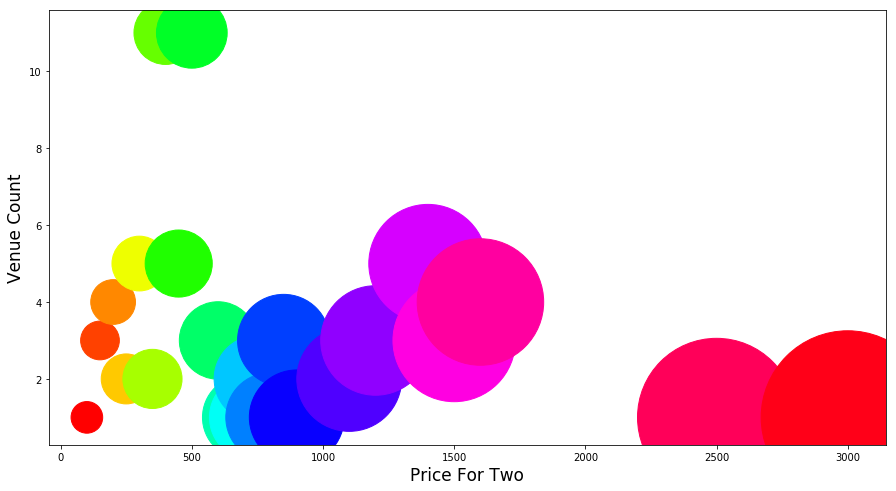

In [19]:
average_prices = data['Price'].value_counts().sort_index()
plt.figure(figsize = (15, 8))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.hsv(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price For Two", fontsize = 17)
plt.ylabel("Venue Count", fontsize = 17)

Now lets **map the venues based on their price range**, where **1.0 refers to similar prices & 4.0 refers to very dissimilar prices**. Color Code :
* 1.0 is **darkblue**
* 2.0 is **lightblue**
* 3.0 is **green**
* 4.0 is **red**

In [20]:
color_map = {'1.0': 'darkblue', '2.0': 'lightblue', '3.0': 'green', '4.0': 'red'}

chennai_map_prices = folium.Map(location = [chennai_latitude,chennai_longitude], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(data['Venue Name'], 
                                                           data['Venue Address'], 
                                                           data['Latitude'], 
                                                           data['Longitude'], 
                                                           data['Price Range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(chennai_map_prices)  
chennai_map_prices

# Clustering

 Lets being the clustering phase. We will be using **K-Means Clustering** to cluster the data. Initially **we must drop the string data**, since it cannot be used during the clustering. **We must assign numerical data to those string values**. We can **drop unwanted values such as Address, Name, ...**

In [21]:
from sklearn.cluster import KMeans
clustering_data = data.drop(columns = ['Category','Venue Name','Venue Address','Review'])
clustering_data

,Latitude,Longitude,Price,Price Range,Rating
1,13.0659,80.2712,100.0,1.0,4.8
2,13.0722,80.2479,300.0,1.0,4.5
3,13.0636,80.2597,750.0,2.0,4.2
4,13.0903,80.2791,450.0,1.0,4.4
5,13.0603,80.2545,500.0,2.0,3.1
7,13.0554,80.2579,850.0,2.0,4.0
8,13.0672,80.2523,1600.0,3.0,4.5
9,13.0856,80.2545,250.0,1.0,4.5
10,13.0666,80.2690,500.0,2.0,4.0
11,13.0600,80.2541,450.0,1.0,4.5


Now **to find the best K-value for clustering** we use the **elbow method**.

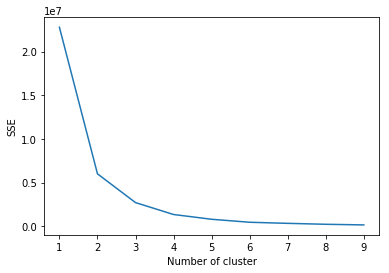

In [22]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(clustering_data)
    clustering_data["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

From the Graph, we can see that **k = 3 is the elbow point** and hence will be the best value for clustering.  

Now we **fit the data to the KMeans model and run the clustering algorithm.**

In [23]:
k = 3
kMeans = KMeans(n_clusters = k, random_state = 0).fit(clustering_data)
data.insert(0, 'Cluster Number', kMeans.labels_)
data.head(5)

,Cluster Number,Category,Venue Name,Latitude,Longitude,Price,Price Range,Rating,Venue Address,Review
1,0,Dessert Shop,Bombay Lassi,13.0659,80.2712,100.0,1.0,4.8,"8, Bahar Agan Street, Anna Salai, Ellis Road, ...",Excellent
2,0,Indian Restaurant,Shree Mithai,13.0722,80.2479,300.0,1.0,4.5,"18, Dr TV Road, Chetpet, Chennai",Excellent
3,0,Café,Nicky's Cafe & Fine Pastries,13.0636,80.2597,750.0,2.0,4.2,"Fagun Mansion, 74, Ethiraj Salai, Egmore, Chennai",Good
4,0,Indian Restaurant,Kakada Ramprasad,13.0903,80.2791,450.0,1.0,4.4,"348/343, Ground Floor, Mint Street, Sowcarpet,...",Excellent
5,0,Juice Bar,The Cake World,13.0603,80.2545,500.0,2.0,3.1,"11/2, Greams Road, Near Police Station, Thousa...",Average


Let us **now assign colors to data according to their clusters** and **map them using the folium library**.

In [24]:
chennai_clusters_map = folium.Map(location = [chennai_latitude,chennai_longitude], zoom_start = 13)
color_map = { 0: 'purple', 1: 'red', 2: 'black'}
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(data['Venue Name'], 
                                                        data['Venue Address'], 
                                                        data['Cluster Number'], 
                                                        data['Latitude'], 
                                                        data['Longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(chennai_clusters_map)

for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(chennai_clusters_map)
chennai_clusters_map

### Cluster - 0

In [25]:
result = data[data['Cluster Number'] == 0]
print("Cluster 0 :\nAverage Price for two : {:.02f}\nAverage Rating : {:.02f}".
      format(result['Price'].mean(), result['Rating'].astype(float).mean()))
result.head(10).reset_index(drop = True)

Cluster 0 :
Average Price for two : 449.64
Average Rating : 3.94


,Cluster Number,Category,Venue Name,Latitude,Longitude,Price,Price Range,Rating,Venue Address,Review
0,0,Dessert Shop,Bombay Lassi,13.0659,80.2712,100.0,1.0,4.8,"8, Bahar Agan Street, Anna Salai, Ellis Road, ...",Excellent
1,0,Indian Restaurant,Shree Mithai,13.0722,80.2479,300.0,1.0,4.5,"18, Dr TV Road, Chetpet, Chennai",Excellent
2,0,Café,Nicky's Cafe & Fine Pastries,13.0636,80.2597,750.0,2.0,4.2,"Fagun Mansion, 74, Ethiraj Salai, Egmore, Chennai",Good
3,0,Indian Restaurant,Kakada Ramprasad,13.0903,80.2791,450.0,1.0,4.4,"348/343, Ground Floor, Mint Street, Sowcarpet,...",Excellent
4,0,Juice Bar,The Cake World,13.0603,80.2545,500.0,2.0,3.1,"11/2, Greams Road, Near Police Station, Thousa...",Average
5,0,Movie Theater,Blur Cafe,13.0554,80.2579,850.0,2.0,4.0,"8, 5th Floor, Sathyam Cinemas Complex, Thiruvi...",Good
6,0,Hotel,Welcome Hotel,13.0856,80.2545,250.0,1.0,4.5,"112/241, Purasawalkam High Road, Purasavakkam,...",Excellent
7,0,Indian Restaurant,Mathura Restaurant,13.0666,80.2690,500.0,2.0,4.0,"826, 2nd Floor, Tarapore Towers, Anna Salai, T...",Good
8,0,Kebab Restaurant,Kabab Corner,13.0600,80.2541,450.0,1.0,4.5,"12/1, Opposite Royal Enfield Showroom, Egmore,...",Excellent
9,0,Donut Shop,Krispy Kreme,13.0589,80.2639,400.0,1.0,4.3,"Upper Ground Floor, Express Avenue, Whites Roa...",Excellent


### Cluster - 1

In [26]:
result = data[data['Cluster Number'] == 1]
print("Cluster 1 :\nAverage Price for two : {:.02f}\nAverage Rating : {:.02f}".
      format(result['Price'].mean(), result['Rating'].astype(float).mean()))
result.head(10).reset_index(drop = True)

Cluster 1 :
Average Price for two : 1394.12
Average Rating : 4.28


,Cluster Number,Category,Venue Name,Latitude,Longitude,Price,Price Range,Rating,Venue Address,Review
0,1,Seafood Restaurant,The Marina,13.0672,80.2523,1600.0,3.0,4.5,"39, College Road, Nungambakkam, Chennai",Excellent
1,1,Chocolate Shop,Sandy's Chocolate Laboratory,13.0610,80.2484,1400.0,3.0,4.4,"16, Wallace Garden, 2nd Street, Nungambakkam, ...",Excellent
2,1,Café,Wild Garden Cafe - Amethyst,13.0573,80.2592,1400.0,3.0,4.3,"Whites Road, Royapettah, Chennai",Excellent
3,1,Ice Cream Shop,Tuscana Pizzeria,13.0609,80.2495,1200.0,3.0,4.0,"19, 3rd Street, Wallace Garden Road, Nungambak...",Good
4,1,Italian Restaurant,Little Italy,13.0607,80.2475,1500.0,3.0,4.1,"112, Eldorado Building, Nungambakkam High Road...",Good
5,1,Chinese Restaurant,Dynasty,13.0666,80.2429,1200.0,3.0,4.0,"Harrisons Hotel, 315, Valluvar Kottam High Roa...",Good
6,1,Asian Restaurant,Nasi And Mee,13.0609,80.2497,1200.0,3.0,4.6,"18/24, Yafa Towers, Khader Nawaz Khan Road, Th...",Excellent
7,1,Multiplex,Chili's American Grill & Bar,13.0588,80.2640,1400.0,3.0,4.8,"49 & 50 L, Express Avenue Mall, White's Road, ...",Excellent
8,1,Café,The Brew Room - The Savera Hotel,13.0458,80.2611,1100.0,3.0,4.4,"The Savera Hotel, 146, RK Salai, Mylapore, Che...",Excellent
9,1,Bar,Sera - The Tapas Bar & Restaurant,13.0458,80.2581,1600.0,3.0,4.3,"71, Cathedral Road, Gopalapuram, Chennai",Excellent


### Cluster - 2

In [27]:
result = data[data['Cluster Number'] == 2]
print("Cluster 2 :\nAverage Price for two : {:.02f}\nAverage Rating : {:.02f}".
      format(result['Price'].mean(), result['Rating'].astype(float).mean()))
result.head(10).reset_index(drop = True)

Cluster 2 :
Average Price for two : 2750.00
Average Rating : 4.15


,Cluster Number,Category,Venue Name,Latitude,Longitude,Price,Price Range,Rating,Venue Address,Review
0,2,Hotel,Beyond Indus - Taj Club House,13.0613,80.2639,2500.0,4.0,4.2,"Taj Club House Hotel, 2, Club House Road, Ann...",Good
1,2,Pool,The Leather Bar - The Park,13.0530,80.2500,3000.0,4.0,4.1,"The Park, 601, Nungambakkam High Road, Nungamb...",Good


# Results & Discussion

Our analysis provides an insight on the venues within a 5km radius of Chennai. We had found that **most venues were located in and around Nungambakkam & Thousand Lights**. The **most common venue category was Indian restaurants, tourists can enjoy the indian cuisine & Chennai's culture**. The city of **chennai mostly consists of venues rated between 3.5 & 4.5**, this is evidence that the **venues are well taken care of and satisfy their customers**. **Most venues had their prices between 500 Rupees & 1500 Rupees**, this is also evidence that the city of **Chennai is an affordable place where you can have a great time at decent prices**.

On Clustering the data collected based on their location, price, price range & rating; we are left with 3 clusters of data.

**Cluster-0** represents venues which are **considerably cheaper & have decent ratings**. We can conclude that Cluster-0 consists of venues where you get the **best value for money**.

**Cluster-1** represents venues with **reasonable prices & great ratings**. We can conclude that Cluster-1 consists of venues where you will have a **great time & experience.**

**Cluster-2** represents venues with **expensive prices & good ratings**. We can conclude that Cluster-2 consists of venues where you can have **luxurious business meetings & a great ambience**.

The above results from the data are merely recommendations to the tourists. In the end, it all comes down to where the tourists want to visit & what they want to do.

# Conclusion

**The whole purpose of this analysis is to provide information to the tourists visiting Chennai to make decisions based on their preferences** and also **promote tourism in Chennai**. We initially **acquired data from FoursquareAPI & ZomatoAPI**. we **cleaned the data** by combining the two datasets & removing venues with similar latitude & longitude co-ordinates. We **dropped venues which were not given ratings** yet. We the **visualized the data in the form of bar plots, scatter plots & maps** to come the conclusions mentioned in the results section. We then **grouped the data into 3 clusters with the help of KMeans Clustering**. The description for each cluster is also mentioned above in the results section. In the end this information will only act as a guide or insight to the tourist. **The tourist is the one who will make the final decision on where they want to visit based on the rating, pricing, location etc.**